## Setting up environment with initial parameters

In [25]:
import torch
import numpy as np
import pandas as pd
import csv
import pyarrow as pa
import pyarrow.parquet as pq
import math
import matplotlib.pyplot as plt
import time

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cuda


In [27]:
n = 28
k = 8
cm_file_path = "output/confusion_matrix.parquet"

## Loading confusion matrix combinations from file

In [28]:
def load_parquet_confusion_matrix(file_path):
    return pd.read_parquet(file_path, engine='pyarrow')

In [29]:
# Loading data from parquet file
cm_df = load_parquet_confusion_matrix(cm_file_path)

print(f"Shape of DataFrame: {cm_df.shape}")
print(cm_df.head())

Shape of DataFrame: (6724520, 8)
   0  1  2  3  4  5  6   7
0  0  0  0  0  0  0  0  28
1  0  0  0  0  0  0  1  27
2  0  0  0  0  0  0  2  26
3  0  0  0  0  0  0  3  25
4  0  0  0  0  0  0  4  24


## Functions for fairness calculations

In [30]:
# Calculating number of confusion matrix combinations from formula 
def calculate_num_of_cm_combinations():
    C = [n + k - 1, k - 1]
    num_combinations = math.factorial(C[0]) / (math.factorial(C[1]) * math.factorial(C[0] - C[1]))
    return int(num_combinations)

In [31]:
def get_imbalance_ratio(df):
    return (df[0] + df[1] + df[4] + df[5]) / (df[0] + df[1] + df[2] + df[3] + df[4] + df[5] + df[6] + df[7])

In [32]:
def get_group_ratio(df):
    return (df[0] + df[1] + df[2] + df[3]) / (df[0] + df[1] + df[2] + df[3] + df[4] + df[5] + df[6] + df[7])

In [33]:
def calculate_accuracy_equality(df):
    return ((df[0] + df[3]) / (df[0] + df[1] + df[2] + df[3])) - ((df[4] + df[7]) / (df[4] + df[5] + df[6] + df[7]))

## Sample fairness calculations

In [34]:
# {TPp, FNp, FPp, TNp, TPup, FNup, FPup, TNup }
df = cm_df.iloc[1000000].values.flatten()

num_combinations = calculate_num_of_cm_combinations()
acc_eq = calculate_accuracy_equality(df)
ir = get_imbalance_ratio(df)
gr = get_group_ratio(df)

print(f"Number of possible matrix = {num_combinations}")
print(f"Accuracy equality = {acc_eq}")
print(f"IR = {ir}")
print(f"GR = {gr}")

Number of possible matrix = 6724520
Accuracy equality = -0.35555555555555557
IR = 0.5714285714285714
GR = 0.35714285714285715


## Histogram for all matrix combinations

In [35]:
# Calculating accuracy equality for histogram
acc_eq_df = calculate_accuracy_equality(cm_df)
print(type(acc_eq_df))
print(acc_eq_df)

<class 'pandas.core.series.Series'>
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
6724515    0.0
6724516    NaN
6724517    NaN
6724518    NaN
6724519    NaN
Length: 6724520, dtype: float64


In [36]:
# Calculating number of NaN values
acc_eq_nan = acc_eq_df.isna().sum()
print(f"Number of NaN values: {acc_eq_nan}")

Number of NaN values: 8990


In [37]:
# Drop NaN values
acc_eq_df.dropna(inplace=True)
print(acc_eq_df)

4495       0.000000
4496       0.037037
4497       0.074074
4498       0.111111
4499       0.148148
             ...   
6724508   -0.037037
6724512    0.000000
6724513    1.000000
6724514    1.000000
6724515    0.000000
Length: 6715530, dtype: float64


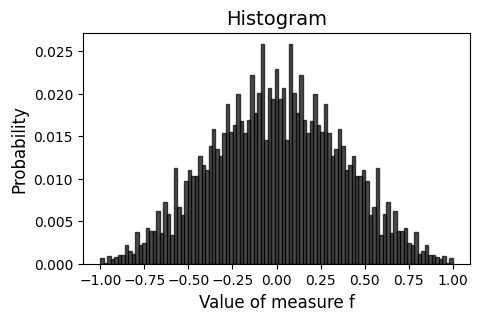

In [38]:
# Plot histogram with probabilities
weights = np.ones_like(acc_eq_df) / len(acc_eq_df)

plt.figure(figsize=(5, 3))
plt.hist(acc_eq_df, bins=101, color='black', edgecolor='black', alpha=0.7, weights=weights)
plt.title("Histogram", fontsize=14)
plt.xlabel("Value of measure f", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.show()

## Histograms for specific IR and GR

In [39]:
# Calculating metrics
cm_df = load_parquet_confusion_matrix(cm_file_path)

cm_df['IR'] = get_imbalance_ratio(cm_df)
cm_df['GR'] = get_group_ratio(cm_df)
cm_df['acc_eq'] = calculate_accuracy_equality(cm_df)
cm_df

,0,1,2,3,4,5,6,7,IR,GR,acc_eq
0,0,0,0,0,0,0,0,28,0.000000,0.000000,NaN
1,0,0,0,0,0,0,1,27,0.000000,0.000000,NaN
2,0,0,0,0,0,0,2,26,0.000000,0.000000,NaN
3,0,0,0,0,0,0,3,25,0.000000,0.000000,NaN
4,0,0,0,0,0,0,4,24,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6724515,27,0,0,0,1,0,0,0,1.000000,0.964286,0.0
6724516,27,0,0,1,0,0,0,0,0.964286,1.000000,NaN
6724517,27,0,1,0,0,0,0,0,0.964286,1.000000,NaN
6724518,27,1,0,0,0,0,0,0,1.000000,1.000000,NaN


In [40]:
# Leaveing records with specific IR value
ir_1_2 = cm_df.loc[(cm_df['IR'] == 27/28) & (cm_df['GR'] == 1/2), ['acc_eq']]
print(ir_1_2)

           acc_eq
1291575  0.071429
1291680  0.000000
1291771 -0.071429
1291849 -0.142857
1291915 -0.214286
...           ...
6608908  0.214286
6608913  0.071429
6608914  0.142857
6608916  0.000000
6608917  0.071429

[840 rows x 1 columns]


Number of NaN values: acc_eq    0
dtype: int64


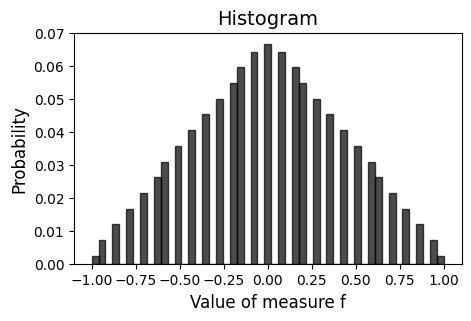

In [41]:
# Ploting histogram for specific IR value
ir_1_2_nan = ir_1_2.isna().sum()
ir_1_2.dropna(inplace=True)
print(f"Number of NaN values: {ir_1_2_nan}")

weights = np.ones_like(ir_1_2) / len(ir_1_2)

plt.figure(figsize=(5, 3))
plt.hist(ir_1_2, bins=51, color='black', edgecolor='black', alpha=0.7, weights=weights)
plt.title("Histogram", fontsize=14)
plt.xlabel("Value of measure f", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.show()

## Memory realese

In [ ]:
del cm_df